<a href="https://colab.research.google.com/github/SeanBarnier/HAFS_Air-Sea/blob/main/fluxAcrossRuns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set up environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install cfgrib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 61.4 MB/s eta 0:00:00


In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import cfgrib

#User parameters

In [4]:
name = "Milton"
tcNum = "14"
trackType = ""

initStart = dt(year=2024, month=10, day=6, hour=0) #Time when Milton began its most rapid intensification
initEnd = dt(year=2024, month=10, day=8, hour=0)

fHourStep = 3       #Normally 3 for HAFS-A
forecastLength = 36 #Normally 126 for HAFS-A.
runStep = 6

figureSuffix = "_RI"
subfolder = "RI/"
dataPath = "/content/drive/MyDrive/savedData/"
figurePath = "/content/drive/MyDrive/figures/"

potentialTemp = True #Use atmospheric potential temperature instead of in-situ temperature

avgTypes = ["point", "centered", "NW", "NE", "SE", "SW"]
areaRange = 1.0

intensityVar = "MSLP" # MSLP or VMAX

atmTop = 850
oceFloor = 100

Get ATCF data and find interested point

#Retrieve HAFS-A Data

Find times needed

In [5]:
fcastTimes = {} #Key: initiation, item: valid time list

initTime = initStart
while initTime <= initEnd:
  validTime = initTime
  fcastTimes[initTime] = []
  fhour = 0

  while fhour <= forecastLength:
    fcastTimes[initTime].append(validTime)
    validTime += pd.Timedelta(hours=fHourStep)
    fhour += fHourStep

  initTime += pd.Timedelta(hours=runStep)

Retrieve Best Track

In [6]:
bt = pd.read_csv(dataPath + "/" + name + "/hurdat2_Milton.csv")

Find storm location in HAFS-A from ATCF files. Used to find along-storm profile.

In [7]:
cols = ["BASIN", "CY", "YYYYMMDDHH", "TECHNUM/MIN", "TECH", "TAU", "LatN/S", "LonE/W",
    "VMAX", "MSLP", "TY", "RAD", "WINDCODE", "RAD1", "RAD2", "RAD3", "RAD4",
    "POUTER", "ROUTER", "RMW", "GUSTS", "EYE", "SUBREGION", "MAXSEAS", "INITIALS",
    "DIR", "SPEED", "STORMNAME", "DEPTH", "SEAS", "SEASCODE", "SEAS1", "SEAS2",
    "SEAS3", "SEAS4", "USERDEFINED1", "Thermo1", "Thermo2", "Thermo3", "Thermo4",
    "Thermo5", "Thermo6", "Thermo7", "USERDEFINED2", "DT", "SHR82", "SHR81_1",
    "SHR82_2",  "USERDEFINED3", "SST", "USERDEFINED4", "ARMW1", "ARMW2"]

In [8]:
tcLocs = {}
tcInt = {}

for runTime in fcastTimes.keys():

  initStr, initHour = runTime.strftime("%Y%m%d_%H").split("_")
  tcLocs[runTime] = {}
  tcInt[runTime] = {}

  atcfURL = f"https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/{initStr}/{initHour}/{tcNum}l.{initStr}{initHour}.hfsa.trak.atcfunix"
  atcfFile = "atcf_" + initStr + "_" + initHour + ".csv"
  !wget -O {atcfFile} {atcfURL}
  atcf = pd.read_csv(atcfFile, names=cols)

  for valid in fcastTimes[runTime]:

    fHour = int((valid-runTime).total_seconds() / 3600)
    pointLat = int(atcf[atcf.TAU==fHour]["LatN/S"].iloc[0].replace("N", ""))/10
    pointLon = int(atcf[atcf.TAU==fHour]["LonE/W"].iloc[0].replace("W", ""))/-10 #Assume western hemisphere
    tcLocs[runTime][valid] = (pointLat, pointLon)
    tcInt[runTime][valid] = int(atcf[atcf.TAU==fHour][intensityVar].iloc[0])

--2025-07-24 14:03:14--  https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/20241006/00/14l.2024100600.hfsa.trak.atcfunix
Resolving noaa-nws-hafs-pds.s3.amazonaws.com (noaa-nws-hafs-pds.s3.amazonaws.com)... 52.216.218.25, 54.231.198.41, 3.5.9.216, ...
Connecting to noaa-nws-hafs-pds.s3.amazonaws.com (noaa-nws-hafs-pds.s3.amazonaws.com)|52.216.218.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33522 (33K) [application/octet-stream]
Saving to: ‘atcf_20241006_00.csv’

atcf_20241006_00.cs 100%[===================>]  32.74K  --.-KB/s    in 0.02s   

2025-07-24 14:03:14 (1.63 MB/s) - ‘atcf_20241006_00.csv’ saved [33522/33522]

--2025-07-24 14:03:14--  https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/20241006/06/14l.2024100606.hfsa.trak.atcfunix
Resolving noaa-nws-hafs-pds.s3.amazonaws.com (noaa-nws-hafs-pds.s3.amazonaws.com)... 52.216.218.25, 54.231.198.41, 3.5.9.216, ...
Connecting to noaa-nws-hafs-pds.s3.amazonaws.com (noaa-nws-hafs-pds.s3.amazonaws.com)|52.216.21

In [9]:
atm = {}

for runTime in fcastTimes.keys():

  initStr = runTime.strftime("%Y%m%d%H")
  atm[runTime] = {}

  for valid in fcastTimes[runTime]:

    atm[runTime][valid] = {}

    fhour = str(int((valid-runTime).total_seconds() / 3600))
    while len(fhour) < 3: fhour = "0" + fhour

    atmFile = "hafsa_" + initStr + "_f" + fhour + ".nc"
    atmPath = dataPath + "hafsaOutput/" + subfolder + atmFile
    atmData = xr.open_dataset(atmPath, decode_timedelta=False )

    point = tcLocs[runTime][valid]
    levels = atmData.isobaricInhPa.data[atmData.isobaricInhPa.data>atmTop]

    for avgType in avgTypes:
      atm[runTime][valid][avgType] = {}

      area = {"NE":[point[0], point[1], point[0]+areaRange, point[1]+areaRange], "SE":[point[0]-areaRange, point[1], point[0], point[1]+areaRange],
        "SW":[point[0]-areaRange, point[1]-areaRange, point[0], point[1],], "NW":[point[0], point[1]-areaRange, point[0]+areaRange, point[1]],
        "centered":[point[0]-(0.5*areaRange), point[1]-(0.5*areaRange), point[0]+(0.5*areaRange), point[1]+(0.5*areaRange)], "point":None}[avgType]

      for level in levels:

        if avgType == "point": validPoint = atmData.sel(latitude=point[0], longitude=point[1] + 360, isobaricInhPa=level, method="nearest")
        else: validPoint = atmData.sel(latitude=slice(area[0], area[2]), longitude=slice(area[1]+360, area[3]+360), isobaricInhPa=level)

        atm[runTime][valid][avgType][level] = {}
        atm[runTime][valid][avgType][level]["T"] = np.mean(validPoint.t.data)
        atm[runTime][valid][avgType][level]["q"] = np.mean(validPoint.q.data) * 1000 #Convert from kg/kg to g/kg
        atm[runTime][valid][avgType][level]["u"] = np.mean(validPoint.u.data)
        atm[runTime][valid][avgType][level]["v"] = np.mean(validPoint.v.data)
        atm[runTime][valid][avgType][level]["gh"] = np.mean(validPoint.gh.data)
        atm[runTime][valid][avgType][level]["sst"] = np.mean(validPoint.sst.data) #Make opposite so that it represents flux into the ocean
        atm[runTime][valid][avgType][level]["shf"] = np.mean(validPoint.ishf.data) * -1
        atm[runTime][valid][avgType][level]["lhf"] = np.mean(validPoint.slhtf.data) * -1
        atm[runTime][valid][avgType][level]["lw"] = np.mean(validPoint.sulwrf.data) * -1
        atm[runTime][valid][avgType][level]["tau"] = (np.mean(validPoint.utaua.data)**2 + np.mean(validPoint.vtaua.data)**2)**0.5

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [10]:
oce = {}
getOce = False

for runTime in fcastTimes.keys():

  if getOce == False: break
  initStr = runTime.strftime("%Y%m%d%H")
  oce[runTime] = {}

  for valid in fcastTimes[runTime]:
    fhour = str(int((valid-runTime).total_seconds() / 3600))
    while len(fhour) < 3: fhour = "0" + fhour
    oceFile = "mom6_" + initStr + "_f" + fhour + ".nc"
    ocePath = dataPath + "mom6Output/" + subfolder + oceFile

    if oceFile == 'mom6_2024100800_f000.nc': #This file is missing
      for layer in oceData.z_l.data:
        oce[initTime][valid][layer] = {"T":np.nan, "s":np.nan, "u":np.nan, "v":np.nan}
      continue

    oceData = xr.open_dataset(ocePath, decode_times=False)

    point = tcLocs[runTime][valid]
    levels = oceData.z_l.data[oceData.z_l.data<=oceFloor] #Retrieves most shallow layer; should be 1 m

    oce[runTime][valid] = {}

    for level in levels:
      oce[runTime][valid][level] = {}
      oce[runTime][valid][level]["T"] = float(oceData.sel(yh=point[0], xh=point[1], z_l=level, method="nearest").temp.data) + 273.15 #This is potential temperature. Converted from C to K.
      oce[runTime][valid][level]["s"] = float(oceData.sel(yh=point[0], xh=point[1], z_l=level, method="nearest").so.data)
      oce[runTime][valid][level]["u"] = float(oceData.sel(yh=point[0], xq=point[1], z_l=level, method="nearest").uo.data)
      oce[runTime][valid][level]["v"] = float(oceData.sel(yq=point[0], xh=point[1], z_l=level, method="nearest").vo.data)
      oce[runTime][valid][level]["sst"] = float(oceData.sel(yh=point[0], xh=point[1], method="nearest").SST.data) + 273.15
      oce[runTime][valid][level]["ssh"] = float(oceData.sel(yh=point[0], xh=point[1], method="nearest").SSH.data)
      oce[runTime][valid][level]["shf"] = float(oceData.sel(yh=point[0], xh=point[1], method="nearest").sensible.data)
      oce[runTime][valid][level]["lhf"] = float(oceData.sel(yh=point[0], xh=point[1], method="nearest").latent.data)

Calculate model MAE

In [11]:
mae = {}
for runTime in fcastTimes.keys():
  mae[runTime] = np.mean([np.abs(tcInt[runTime][valid]-bt[intensityVar.lower()][bt.time==valid.strftime("%Y-%m-%d %H:%M:%S")].iloc[0]) for valid in fcastTimes[runTime] if valid.hour%6 == 0])

#Figures

Sensible heat flux with intensity

In [12]:
avgType = "centered"

atm_12hr = {}
for runTime in fcastTimes.keys():
  if runTime.hour%12 == 0: atm_12hr[runTime] = atm[runTime]

# Get the number of model runs
num_runs = len(atm_12hr)

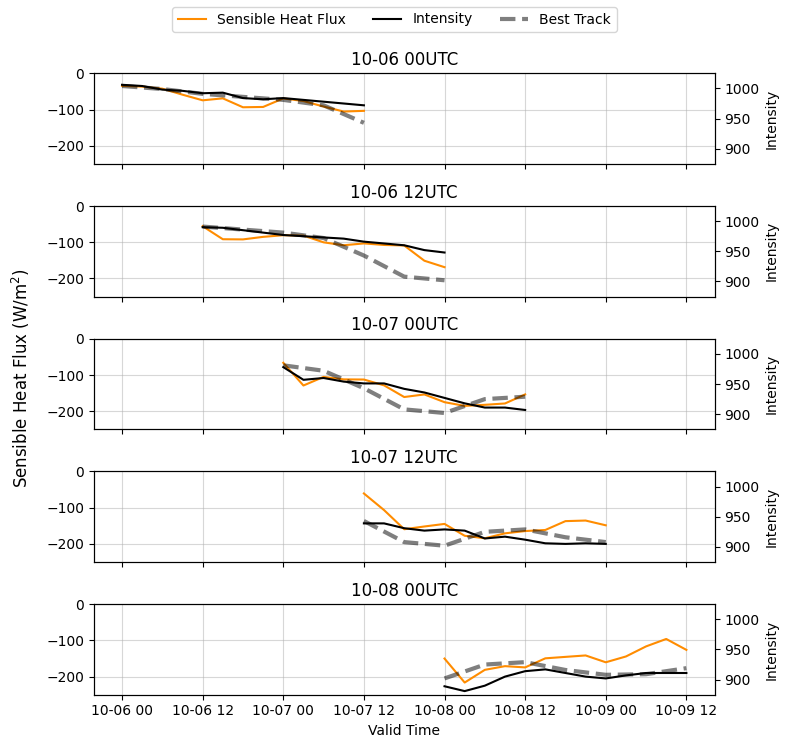

In [13]:
# Get the number of model runs
num_runs = len(atm_12hr)

# Create a figure with a subplot for each run time
fig, axes = plt.subplots(num_runs, 1, figsize=(8, 1.5 * num_runs), sharex=True)

# Ensure axes is an array even if there's only one run
if num_runs == 1: axes = [axes]

for i, (run_time, valid_times_data) in enumerate(atm_12hr.items()):
    times = sorted(valid_times_data.keys())
    shf_values = [valid_times_data[time][avgType][1000.0]["shf"] for time in times]
    intensity_values = [tcInt[run_time][time] for time in times] # Get intensity values
    int6hr = [tcInt[run_time][time] for time in times if time.hour%6 == 0]
    bt_values = [bt[intensityVar.lower()][pd.to_datetime(bt.time)==time].iloc[0] for time in times if time.hour%6 == 0]

    ax1 = axes[i]
    ax2 = ax1.twinx()

    fluxPlot = ax1.plot(times, shf_values, color="darkorange")
    intPlot = ax2.plot(times, intensity_values, color="black")
    btPlot = ax2.plot([time for time in times if time.hour%6 == 0], bt_values, color="black", alpha=0.5, linestyle="--", linewidth=3)

    ax2.set_ylabel("Intensity")
    ax1.set_title(run_time.strftime("%m-%d %HUTC"))# + ", " + "r$_{Model}$ = " + str(round(np.corrcoef(shf_values,intensity_values)[0,1], 2)) + ", " + "r$_{BT}$ = " + str(round(np.corrcoef(int6hr,bt_values)[0,1], 2)))
    ax1.grid(alpha=0.5)

    ax1.set_ylim(-250, 0)
    ax2.set_ylim(875, 1025)

fluxPlot[0].set_label('Sensible Heat Flux')
intPlot[0].set_label('Intensity')
btPlot[0].set_label('Best Track')
fig.legend(loc="upper center", ncols=3)

# Set common x-label for the last subplot
axes[-1].set_xlabel("Valid Time")
fig.supylabel("Sensible Heat Flux (W/m$^2$)")
fig.suptitle(" ")
plt.tight_layout()
plt.show()

Latent heat flux and intensity

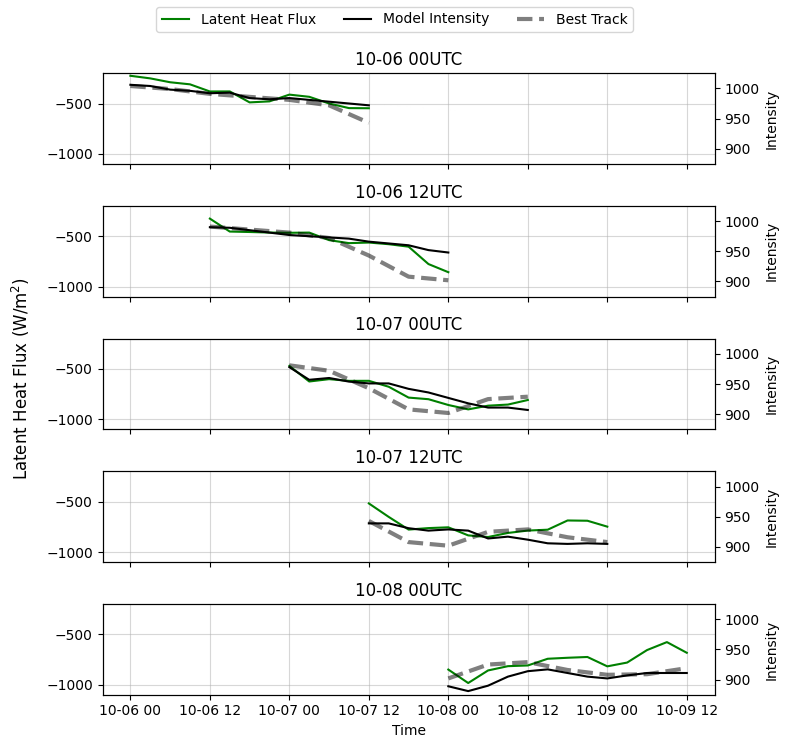

In [14]:
# Get the number of model runs
num_runs = len(atm_12hr)

# Create a figure with a subplot for each run time
fig, axes = plt.subplots(num_runs, 1, figsize=(8, 1.5 * num_runs), sharex=True)

# Ensure axes is an array even if there's only one run
if num_runs == 1: axes = [axes]

for i, (run_time, valid_times_data) in enumerate(atm_12hr.items()):
    times = sorted(valid_times_data.keys())
    lhf_values = [valid_times_data[time][avgType][1000.0]["lhf"] for time in times]
    intensity_values = [tcInt[run_time][time] for time in times] # Get intensity values
    int6hr = [tcInt[run_time][time] for time in times if time.hour%6 == 0]
    bt_values = [bt[intensityVar.lower()][pd.to_datetime(bt.time)==time].iloc[0] for time in times if time.hour%6 == 0]

    ax1 = axes[i]
    ax2 = ax1.twinx()

    fluxPlot = ax1.plot(times, lhf_values, color="green")
    intPlot = ax2.plot(times, intensity_values, color="black")
    btPlot = ax2.plot([time for time in times if time.hour%6 == 0], bt_values, color="black", alpha=0.5, linestyle="--", linewidth=3)

    ax2.set_ylabel("Intensity")
    ax1.set_title(run_time.strftime("%m-%d %HUTC"))# + ", " + "r$_{Flux-Model}$ = " + str(round(np.corrcoef(lhf_values,intensity_values)[0,1], 2)) + ", " + "r$_{Model-BT}$ = " + str(round(np.corrcoef(int6hr,bt_values)[0,1], 2)))
    ax1.grid(alpha=0.5)

    ax1.set_ylim(-1100, -200)
    ax2.set_ylim(875, 1025)

fluxPlot[0].set_label('Latent Heat Flux')
intPlot[0].set_label('Model Intensity')
btPlot[0].set_label('Best Track')
fig.legend(loc="upper center", ncols=3)

axes[-1].set_xlabel("Time")
fig.supylabel("Latent Heat Flux (W/m$^2$)")
fig.suptitle(" ")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Sensible + Latnet heat flux and Intensity

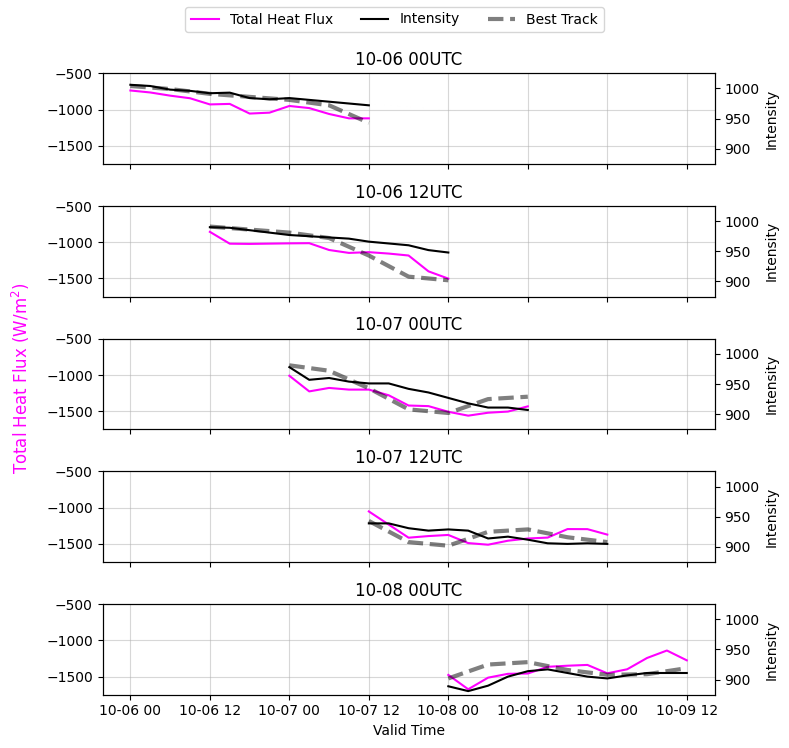

In [24]:
# Create a figure with a subplot for each run time
fig, axes = plt.subplots(num_runs, 1, figsize=(8, 1.5 * num_runs), sharex=True)

# Ensure axes is an array even if there's only one run
if num_runs == 1: axes = [axes]

for i, (run_time, valid_times_data) in enumerate(atm_12hr.items()):
    if run_time.hour%12 != 0: continue
    times = sorted(valid_times_data.keys())
    hf_values = [valid_times_data[time][avgType][1000.0]["lhf"]+valid_times_data[time][avgType][1000.0]["shf"]+valid_times_data[time][avgType][1000.0]["lw"] for time in times]
    intensity_values = [tcInt[run_time][time] for time in times] # Get intensity values
    int6hr = [tcInt[run_time][time] for time in times if time.hour%6 == 0]
    bt_values = [bt[intensityVar.lower()][pd.to_datetime(bt.time)==time].iloc[0] for time in times if time.hour%6 == 0]

    ax1 = axes[i]
    ax2 = ax1.twinx()

    fluxPlot = ax1.plot(times, hf_values, color="magenta")
    intPlot = ax2.plot(times, intensity_values, color="black")
    btPlot = ax2.plot([time for time in times if time.hour%6 == 0], bt_values, color="black", alpha=0.5, linestyle="--", linewidth=3)

    ax2.set_ylabel("Intensity")
    ax1.set_title(run_time.strftime("%m-%d %HUTC"))# + ", " + "r$_{Flux-Model}$ = " + str(round(fluxIntCorr[run_time], 2)) + ", " + "r$_{Model-BT}$ = " + str(round(np.corrcoef(int6hr,bt_values)[0,1], 2)))
    ax1.grid(alpha=0.5)

    ax1.set_ylim(-1750, -500)
    if intensityVar.lower()=="vmax": ax2.set_ylim(80, 160)
    if intensityVar.lower()=="mslp": ax2.set_ylim(875, 1025)

fluxPlot[0].set_label('Total Heat Flux')
intPlot[0].set_label('Intensity')
btPlot[0].set_label('Best Track')
fig.legend(loc="upper center", ncols=3)

axes[-1].set_xlabel("Valid Time")
fig.supylabel("Total Heat Flux (W/m$^2$)", color="magenta")
fig.suptitle(" ")
plt.tight_layout()
plt.show()

Correlation between model intensity and flux for each run

In [16]:
fluxIntCorr = {}

for i, (run_time, valid_times_data) in enumerate(atm.items()):
    times = sorted(valid_times_data.keys())
    hf_values = [valid_times_data[time][avgType][1000.0]["lhf"]+valid_times_data[time][avgType][1000.0]["shf"]-valid_times_data[time][avgType][1000.0]["lw"] for time in times]
    intensity_values = [tcInt[run_time][time] for time in times] # Get intensity values
    bt_values = [bt[intensityVar.lower()][pd.to_datetime(bt.time)==time].iloc[0] for time in times if time.hour%6 == 0]

    fluxIntCorr[run_time] = np.corrcoef(hf_values,intensity_values)[0,1]

Text(0, 0.5, 'r(Flux, Model Intensity)')

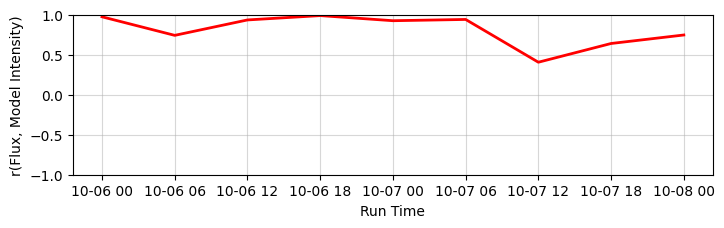

In [17]:
corFig = plt.figure(figsize=(8, 2))
corAx = corFig.add_axes([0.1, 0.1, 0.8, 0.8])
corAx.plot(fluxIntCorr.keys(), fluxIntCorr.values(), color="red", lw=2)

corAx.set_ylim(-1, 1)
corAx.grid(alpha=0.5)
corAx.set_xticks(list(fcastTimes.keys()))
corAx.set_xticklabels([t.strftime("%m-%d %H") for t in list(fcastTimes.keys())])
corAx.set_xlabel("Run Time")
corAx.set_ylabel("r(Flux, Model Intensity)")

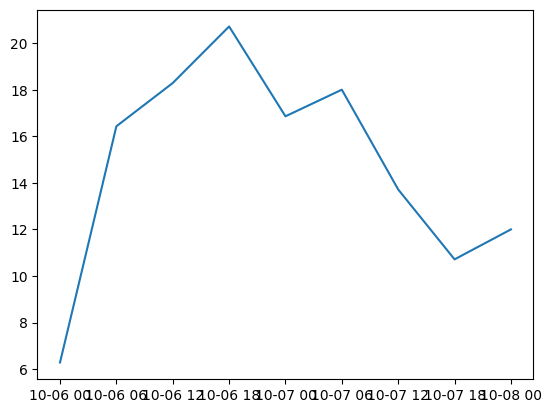

In [18]:
plt.plot(mae.keys(), mae.values())

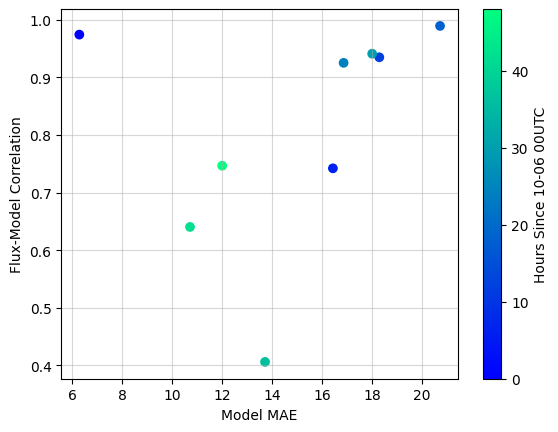

In [19]:
tdeltas = [(t-initStart).total_seconds()/3600 for t in fcastTimes.keys()]
maeScatter = plt.scatter([mae[runTime] for runTime in fcastTimes], [fluxIntCorr[runTime] for runTime in fcastTimes], cmap="winter", c=tdeltas)
plt.colorbar(maeScatter, label="Hours Since " + initStart.strftime("%m-%d %HUTC"))
plt.xlabel("Model MAE")
plt.ylabel("Flux-Model Correlation")
plt.grid(alpha=0.5)
plt.show()

Analysis of Flux Differences across Runs

In [20]:
validFluxes = {}
for runTime in fcastTimes.keys():
  for valid in fcastTimes[runTime]:
    validFluxes[valid] = []

In [21]:
for runTime, validTimes in fcastTimes.items():
  for valid in validTimes:
    validFluxes[valid].append(atm[runTime][valid][avgType][1000.0]["shf"] + atm[runTime][valid][avgType][1000.0]["lhf"] + atm[runTime][valid][avgType][1000.0]["lw"])

meanFluxes = {valid:np.mean(fluxes) for valid, fluxes in validFluxes.items()}

In [22]:
fluxDiffs = {}
for runTime, validTimes in fcastTimes.items():
  fluxDiffs[runTime] = np.mean([((atm[runTime][valid][avgType][1000.0]["shf"] + atm[runTime][valid][avgType][1000.0]["lhf"]) - meanFluxes[valid]) for valid in validTimes])

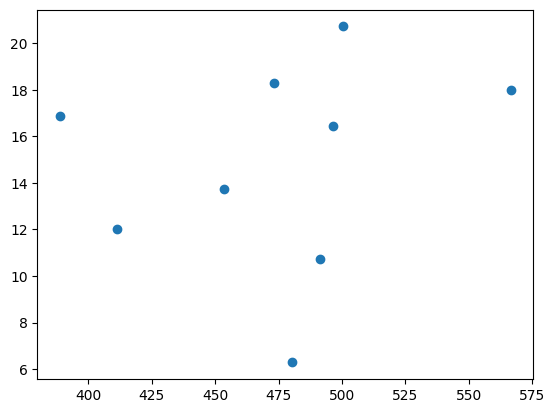

In [23]:
plt.scatter(fluxDiffs.values(), mae.values()) #It's actually kinda hilarious how little they have to do with each other.